In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import sklearn
import yellowbrick
import re
import mglearn
import boto3
from s3 import get_file

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
s3 = boto3.resource('s3')
lyrics = get_file(s3,'s3ssp',download_file='NLP_Data/master_lyrics_audio_features.csv',rename_file='nlp.csv')

In [3]:
df = pd.read_csv(lyrics,sep='|',encoding='utf-8')
df_demo = df.copy().dropna()

In [4]:
df_demo.sample()

,artist_name,track_name,track_uri,lyrics,acousticness,danceability,energy,valence,instrumentalness,key,mode,liveness,speechiness,time_signature,tempo,loudness
36406,Dave Mason,maybe,4NyUDFUvUd4eZxkaMJvaDf,"Maybe I love , friend I ; troubles mend , sing...",0.618,0.616,0.312,0.169,0.000003,0.0,0.0,0.0754,0.0266,4.0,136.118,-11.943


In [5]:
#Control Panel - Hyper Parameters

#Count Vectorizer
max_features = 100 #500
max_df = .10



#LDA
n_components = 5  #10


#LDA Display
display_n_chunks = 5 #5
n_components = 5        #20
n_words = 20       #5



## Top Word Count

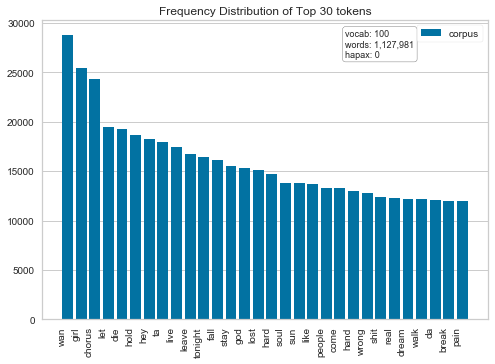

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

from yellowbrick.text import FreqDistVisualizer

# Load the text data


vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
docs      = vect.fit_transform(df_demo['lyrics'])
features   = vect.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v',n=30)
visualizer.fit(docs)
visualizer.show()

## Topic Analysis

In [7]:
#Count Vectorizer
vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
X = vect.fit_transform(df_demo['lyrics'])

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=n_components, learning_method="batch",
                                max_iter=15, random_state=0)


# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once

document_topics = lda.fit_transform(X)

print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)#[:, ::-1]


# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(n_components), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words)





lda.components_.shape: (5, 100)
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
ich           ich           ich           ich           nigga         
nigga         da            la            da            fuck          
die           la            da            la            ooh           
la            nigga         hey           nigga         shit          
fuck          fuck          dance         fuck          wan           
death         rain          sing          shit          chorus        
god           ooh           tonight       hey           hey           
chorus        tonight       broken        ooh           em            
tears         god           tears         em            ta            
shit          tears         rain          rock          tonight       
rain          broken        chorus        ta            rock          
broken        shit          waiting       mon

## Assemble Playlist

In [9]:
def get_playlist_elements(components=range(n_components), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words):
    topics_words = []
    
    for i in range(0, len(components), topics_per_chunk):
        # for each chunk:
        these_topics = components[i: i + topics_per_chunk]
        
        for t in these_topics:
            
            topic_words = []
            
            for i in range(n_words):
                
                try:
                    #print(("{:<14}" * len_this_chunk).format(
                    #    *feature_names[sorting[these_topics, i]]))
                    topics_words.append({'topic':f'topic{t}','word':feature_names[sorting[these_topics, i]][t]})
                except:
                    pass
        
    return topics_words

In [10]:
playlist_elements = get_playlist_elements()

In [11]:
df_playlist_elements = pd.DataFrame(playlist_elements)

In [12]:
list_df_words = df_playlist_elements['word'].tolist()
list_df_topics = set(df_playlist_elements['topic'].tolist())

In [13]:
def find_lyrics(lyrics,element,track_uri):
    
    if(lyrics.find(element)!= -1):
        
        return track_uri
    
    else:
        
        return None


In [14]:
def make_ssp(topics,words):
    topics_words = df_playlist_elements.copy()
    
    df_lyrics = df_demo.copy()
    
    df_empty = pd.DataFrame()
    
    ssp = []
    
    #Set df_demo_ssp to topic number

    topics_words = topics_words[(topics_words['topic']== f'topic{topic}')]
    
    df_demo_ssp_wordset = topics_words['word'].tolist()

    for word in df_demo_ssp_wordset:
        
        df_empty[f'{word}'] = df_lyrics.apply(lambda x: find_lyrics(x['lyrics'],word,x['track_uri']),axis=1)



    return df_empty


## Takes 8 minutes

In [15]:
list_ssp = []

for topic in range(len(list_df_topics)):
    
    ssp = make_ssp(topic,list_df_words)

    
    df_ssp = ssp.dropna(how='all')
    
    for x in range(100):
        
        for col in df_ssp.columns:
            
            df_ssp_col = df_ssp[col].dropna(how='any')
            
            col_track_uri = df_ssp_col.sample(1).values
            
            list_ssp.append({'playlist':f'topic{topic}playlist{x}','track_uri':col_track_uri[0]})


In [19]:
sample_ssp = pd.DataFrame(list_ssp)
df_track_ssp = sample_ssp.merge(df_demo,left_on='track_uri',right_on='track_uri')
df_agg_ssp = sample_ssp.merge(df_demo,left_on='track_uri',right_on='track_uri').groupby('playlist').median()

In [48]:
ssp = df_track_ssp[df_track_ssp['playlist']=='topic0playlist1'].sort_values(by='valence',ascending=True)

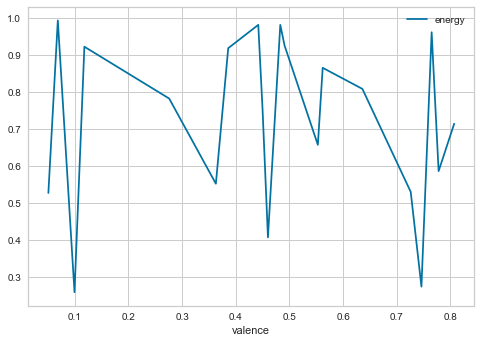

In [49]:
ssp.plot.line(x='valence',y='energy')

## Save SSP

In [34]:
#df_sample_ssp.to_csv('test_ssp.csv',sep='|',index=True)

## Below is Under Development

In [35]:
## Visualization (Valence Curve, Energy Curve)

In [36]:
## Create Spotify Playlist

In [42]:
import requests
import json
import pandas as pd
import spotipy#authentication
import spotipy.util as util#authentication
from spotipy.oauth2 import SpotifyClientCredentials#authentication

In [43]:
cid = '049ade7215e54c63a2b628f3784dc407'
secret = '5d30770120ad4dbbabbb5ce538110e05'
redirect_uri = 'http://google.com/'
username = 'name'

In [44]:
#Authentication

scope = 'playlist-modify-private'
token_playlist = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_playlist:
    
    sp_playlist = spotipy.Spotify(auth=token_playlist)

else:
    
    print("Can't get token for", username)
    
#Authentication

scope = 'user-read-private'

token_user = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_user:
    sp_user = spotipy.Spotify(auth=token_user)
else:
    print("Can't get token for", username)

Enter the URL you were redirected to: https://www.google.com/?code=AQBtZHiWhthDmgqiB8eXIUwe1MTmCu_9AJMnMMseRlpmQQhI5rbEdCUUHC00gM7wg9uJCJd-pT_U7qsrUuJfSC5Ev-Jk9Cc0aM8LPNuEpZOHzB7dNIEPcRa0Ms7S9aegQGhjfI-cbzKahvJQyQgexkWzJEHniUVil1_dKfRuUcC_7bJi4u-J0u-YT4qljvwVNgPy_FMGNLZBdZyW1usqt9U
Enter the URL you were redirected to: https://www.google.com/?code=AQALg_ZmCoiW9Cd2vc5PcwHqNZajv6iFPeU3cIYnrBM6rIabfIoYjVuCe2_XOgOTJIgO0kJA1CvMbk68g4m0wzJMT5XzW1I7mu9AUovxWVzotmbImwzquN2pGmJAb8XPmUAJ_Kfy2z_JZ_7NZOXd1HeBD3YAhs2OuKvMknoSz1xvxBruCen4O2wT_recetYr2r1F0swMd_ntjC0


In [50]:
def get_user_id(url):
    try:
        resp = requests.get(url,headers={'Authorization': 'Bearer ' + token_user},
                             #data={"name": "SSP"}
                           )
        
        resp.raise_for_status()
        
    except requests.exceptions.HTTPError as err:
        
        print(err)
        
    
    response = resp.json()
    userid = response['id']
    
    return userid


In [51]:
user_id = get_user_id('https://api.spotify.com/v1/me')

In [52]:
identification = user_id
identification

'124399179'

In [53]:
playlist = sp_playlist.user_playlist_create(identification,'SSP_Ideal', public=False, description="Ideal SSP")

In [54]:
playlist

{'collaborative': False,
 'description': 'Ideal SSP',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/0dyEIKTpoWrFDI7ktkn7ws'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/0dyEIKTpoWrFDI7ktkn7ws',
 'id': '0dyEIKTpoWrFDI7ktkn7ws',
 'images': [],
 'name': 'SSP_Ideal',
 'owner': {'display_name': 'Adam Goldstein',
  'external_urls': {'spotify': 'https://open.spotify.com/user/124399179'},
  'href': 'https://api.spotify.com/v1/users/124399179',
  'id': '124399179',
  'type': 'user',
  'uri': 'spotify:user:124399179'},
 'primary_color': None,
 'public': False,
 'snapshot_id': 'MSxiOTA1NjFjNDVhYzMzZGFkYzRjNmM1ZDUwZWJhNDY4ZWY4ZTlmMDBk',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/0dyEIKTpoWrFDI7ktkn7ws/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:playlist:0dyEIKTpoWrFDI7ktkn7ws'}

In [55]:
playlist_tracks = sp_playlist.user_playlist_add_tracks(identification,playlist['id'],ssp['track_uri'], position=None)

## End

## Sample Topic Analysis Code

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {i}:".format(i=topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#How many words per topic
no_top_words = 4
display_topics(nmf, tfidf_feature_names, no_top_words)